In [6]:
import random
import simpy
import logging
import sys
import scipy.stats as ss

DEBUG = False
if DEBUG:
    logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

RANDOM_SEED = 42
NUM_CUSTOMERS = 500  # Total number of customers
INTERVAL_CUSTOMERS = 5  # Generate new customers roughly every x seconds
LINE_TOLERANCE = 6  # large number for now
SIM_TIME = 3600
AVG_SERVE_TIME = 60  # service time (in seconds) per customer

# service parameters of the supermarket
service_capacity = 1
num_counters = 5

# Earnings variables
gross_margin_per_customer = 10  # dollars
cost_per_counter = 300  # dollars


def count_customers(counter):
    """Total number of customers in the counter"""
    return max([0, len(counter.queue) + len(counter.users)])


class Customer:
    """Customer arrives, is served and leaves."""

    def __init__(self, env, name, model=None, choose_method='shortest'):
        """Setup of customer, then spawn a process"""
        self.arrive = env.now
        self.env = env
        self.name = name
        self.choose_method = choose_method
        self.model = model

        logging.debug(f'{self.arrive:.2f} {self.name}: Arrived in the supermarket')
        self.process = env.process(self.run())

    def run(self):
        env = self.env
        counters = self.model.counters
        model = self.model
        choice, queue_length = self.choose(counters, method=self.choose_method)
        line_tolerance = ss.poisson(LINE_TOLERANCE).rvs()

        if queue_length > line_tolerance:  # lines are too long
            logging.debug(
                f'{env.now:.2f} {self.name}: left_long_line after {self.wait:.3f}')
            model.waiting_times.append({'time': env.now,
                                        'wait': 0,
                                        'total_time': -1,
                                        'type': 'long line'})  # -1 means left because of long lines
            model.counter_queues.append(
                {i: count_customers(counters[i]) for i in range(len(counters))})

        with counters[choice].request() as req:
            # Wait for the counters or abort at the end of our tether
            results = yield req

            wait = self.wait

            if req in results:
                # We got to the counters
                logging.debug(f'{env.now:.2f} {self.name}: Waited {wait:.3f}')

                # poisson process has exponential inter-arrival times
                serve_time = random.expovariate(1.0 / AVG_SERVE_TIME)
                yield env.timeout(serve_time)
                logging.debug(f'{env.now:.2f} {self.name}: Finished')
                model.waiting_times.append({'time': env.now,
                                            'wait': wait,
                                            'total_time': wait+serve_time,
                                            'type': 'served'})
                model.counter_queues.append(
                    {i: count_customers(counters[i]) for i in range(len(counters))})


    def choose(self, counters, method):
        queue_lengths = [count_customers(counters[i])
                         for i in range(len(counters))]
        if method == 'shortest':
            for choice_idx in range(len(queue_lengths)):
                queue_length = queue_lengths[choice_idx]
                if queue_length == 0 or queue_length == min(queue_lengths):
                    break  # choose choice_idx

        if method == 'random':
            choice_idx = random.choice(range(len(queue_lengths)))
            queue_length = queue_lengths[choice_idx]

        return choice_idx, queue_length

    @property
    def wait(self):
        return self.env.now - self.arrive


class QueueModel:
    def __init__(self, num_counters, num_customers, interval_customers, seed=42):
        # Setup and start the simulation
        random.seed(seed)
        self.env = simpy.Environment()
        self.waiting_times = []
        self.counter_queues = []
        self.arrivals_times = []
        # Start processes
        self.counters = [simpy.Resource(self.env, capacity=1)
                         for i in range(num_counters)]
        self.env.process(self.customer_source(
            num_customers, interval_customers))

    def customer_source(self, number, interval):
        """Source generates customers randomly"""
        model = self
        for i in range(number):
            c = Customer(self.env, f'Customer{i:02d}', model)
            t = random.expovariate(1.0 / interval)

            yield self.env.timeout(t)
            model.arrivals_times.append({'time': self.env.now,
                                         'count': i+1})

    def simulate(self, time):
        self.env.run(time)

    def get_customers_served(self):
        return sum([wait['total_time'] > 0 for wait in self.waiting_times])

    def get_gross_margin(self):
        return gross_margin_per_customer * self.get_customers_served()

    def get_operating_costs(self):
        return cost_per_counter * len(self.counters)

    def get_total_profit(self):
        return self.get_gross_margin() - self.get_operating_costs()


model = QueueModel(num_counters, NUM_CUSTOMERS, INTERVAL_CUSTOMERS)
model.simulate(SIM_TIME)


500


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
wait_df = pd.DataFrame(model.waiting_times)
counter_df = pd.DataFrame(model.counter_queues)
arrival_df = pd.DataFrame(model.arrivals_times)

<AxesSubplot:xlabel='time'>

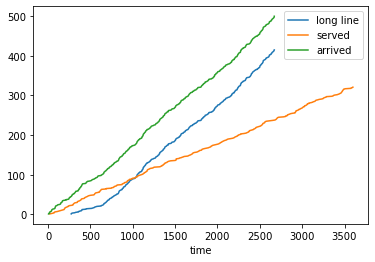

In [8]:
fig, ax = plt.subplots(1)

for key, group in wait_df.groupby('type'):
    group['count'] = np.cumsum(np.ones(len(group)))
    group.plot(x='time', y='count', ax=ax, label=key)
arrival_df.plot(x='time', y='count', ax=ax, label='arrived') # arrived

In [9]:
model.get_total_profit(), model.get_operating_costs(), len(model.waiting_times), len(model.arrivals_times)

(1710, 1500, 736, 500)

## Testing the model

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


<AxesSubplot:xlabel='counters'>

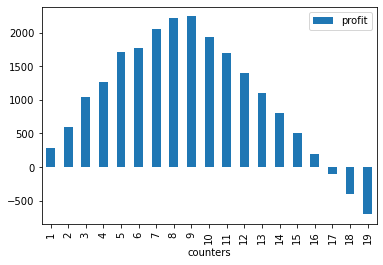

In [10]:
results = []
for num_counters in range(1,20):
    model = QueueModel(num_counters, NUM_CUSTOMERS, INTERVAL_CUSTOMERS)
    model.simulate(SIM_TIME)
    results.append({'counters': num_counters,
                    'profit': model.get_total_profit()})
    
df = pd.DataFrame(results)
df.plot(x='counters', y='profit', kind='bar')

## References

1. https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
2. https://towardsdatascience.com/intro-to-agent-based-modeling-3eea6a070b72
3. https://medium.com/swlh/simulating-a-parallel-queueing-system-with-simpy-6b7fcb6b1ca1
4. Gabriel Gomes (2022) A framework for hybrid simulation of transportation networks, Journal of Simulation, 16:2, 166-181, DOI: 10.1080/17477778.2020.1766387